![Netflix Stock and Twitter Sentiment Analysis](https://image.cnbcfm.com/api/v1/image/107075690-1655227861488-gettyimages-1240448479-RAFAPRESS_04052022-0494.jpeg?v=1681852484&w=929&h=523&vtcrop=y)

# Netflix Stock Prediction Using Twitter Sentiment Analysis
This project aims to predict Netflix stock prices by combining historical stock data with sentiment analysis from Twitter. It facilitates accurate stock prediction by leveraging the impact of social media on market trends. The process involves:

- Data Preparation: Loading historical stock data and Twitter sentiment analysis, followed by data preprocessing and visualization for insights.

- Model Building: Designing an LSTM neural network with Conv1D and Bidirectional LSTM layers. Dropout layers are added to prevent overfitting.

- Training and Validation: Training two models, one with Twitter sentiment and one without. Validation and loss curves are used to evaluate model performance.

- Accuracy Assessment: Evaluating the models' accuracy by comparing predicted and actual stock prices, and assessing training performance.

**Coding sources from github repo for this assignment** [Github repo](https://github.com/KerolosAtef/Stock-market-prediction-using-sentiment-analysis-of-twitter)

# Import relevant libraries
- This step initiates the project by importing essential libraries. It brings in tools for array computations (NumPy), machine learning (TensorFlow), neural network components (Sequential, LSTM, Conv1D, etc.), data handling (pandas), optimization (Adam), visualization (Matplotlib, seaborn), and time manipulation (datetime). Additionally, it includes specialized LSTM layers for efficient training (CuDNNLSTM) and bidirectional LSTM layers (Bidirectional). The predefined seed (seed=42) ensures consistent results across runs.

In [6]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
from datetime import datetime
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

# Load the Dataset

In [7]:
#Read the csv file and show the overview of this dataset
df = pd.read_csv('Final_nflx_data_2018-2022.csv')
df['date'] = pd.to_datetime(df['date'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1137 non-null   datetime64[ns]
 1   Open       1137 non-null   float64       
 2   High       1137 non-null   float64       
 3   Low        1137 non-null   float64       
 4   Close      1137 non-null   float64       
 5   Adj Close  1137 non-null   float64       
 6   Volume     1137 non-null   int64         
 7   P_mean     1137 non-null   float64       
 8   P_sum      1137 non-null   int64         
 9   twt_count  1137 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 89.0 KB


,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2018-01-02,196.100006,201.649994,195.419998,201.070007,201.070007,10966900,0.020833,10,480
1,2018-01-03,202.050003,206.210007,201.500000,205.050003,205.050003,8591400,0.071217,24,337
2,2018-01-04,206.199997,207.050003,204.000000,205.630005,205.630005,6029600,-0.018519,-4,216
3,2018-01-05,207.250000,210.020004,205.589996,209.990005,209.990005,7033200,-0.019737,-6,304
4,2018-01-08,210.020004,212.500000,208.440002,212.050003,212.050003,5580200,-0.007663,-2,261


## Exploring the Time Series Plot
Here's the breakdown of interpretation for each line of code:

1. `import seaborn as sns`: Imports the Seaborn library, which is used for creating visually appealing statistical visualizations.

2. `plt.figure(figsize=(25,7));`: Initiates a new plot with a specified figure size of 25 units wide and 7 units high using the `matplotlib.pyplot` library.

3. `sns.lineplot(x=df["date"], y=df["Adj Close"])`: Creates a line plot using Seaborn's `lineplot` function. This visualizes the historical trend of Netflix's adjusted closing stock prices over time.

4. `df['sentiment_analysis'] = df['P_mean']`: Creates a new column named "sentiment_analysis" in the DataFrame `df`. It assigns the values from the existing "P_mean" column to this new column.

5. `df['sentiment_analysis'] = df['sentiment_analysis'].apply(lambda x: 'pos' if x > 0 else 'nue' if x == 0 else 'neg')`: Modifies the values in the "sentiment_analysis" column based on the values in the "P_mean" column. The lambda function applies categorization: if a value is positive, the label becomes 'positive'; if it's neutral (zero), the label becomes 'neutral'; otherwise, it becomes 'negative'.

6. `sns.scatterplot(x=df["date"], y=df['Adj Close'], hue=df['sentiment_analysis'], palette=['y','r','g'])`: Generates a scatter plot using Seaborn's `scatterplot` function. Different colors ('y' for yellow, 'r' for red, 'g' for green) are provided in the palette for each sentiment category.

7. `plt.xticks(rotation=45);`: Adjusts the rotation of x-axis tick labels. The parameter `rotation=45` specifies a rotation angle of 45 degrees.

8. `plt.title("Stock market of Netflix from Jan-2018 to Jul-2022", fontsize=16);`: Sets the title of the plot to describe the data being visualized. The font size of the title is set to 16.

In summary, this code section employs Seaborn to create a line plot and a scatter plot. The line plot shows Netflix's stock prices over time, while the scatter plot combines stock prices with categorized sentiment analysis results, highlighting potential correlations between sentiment and stock performance.

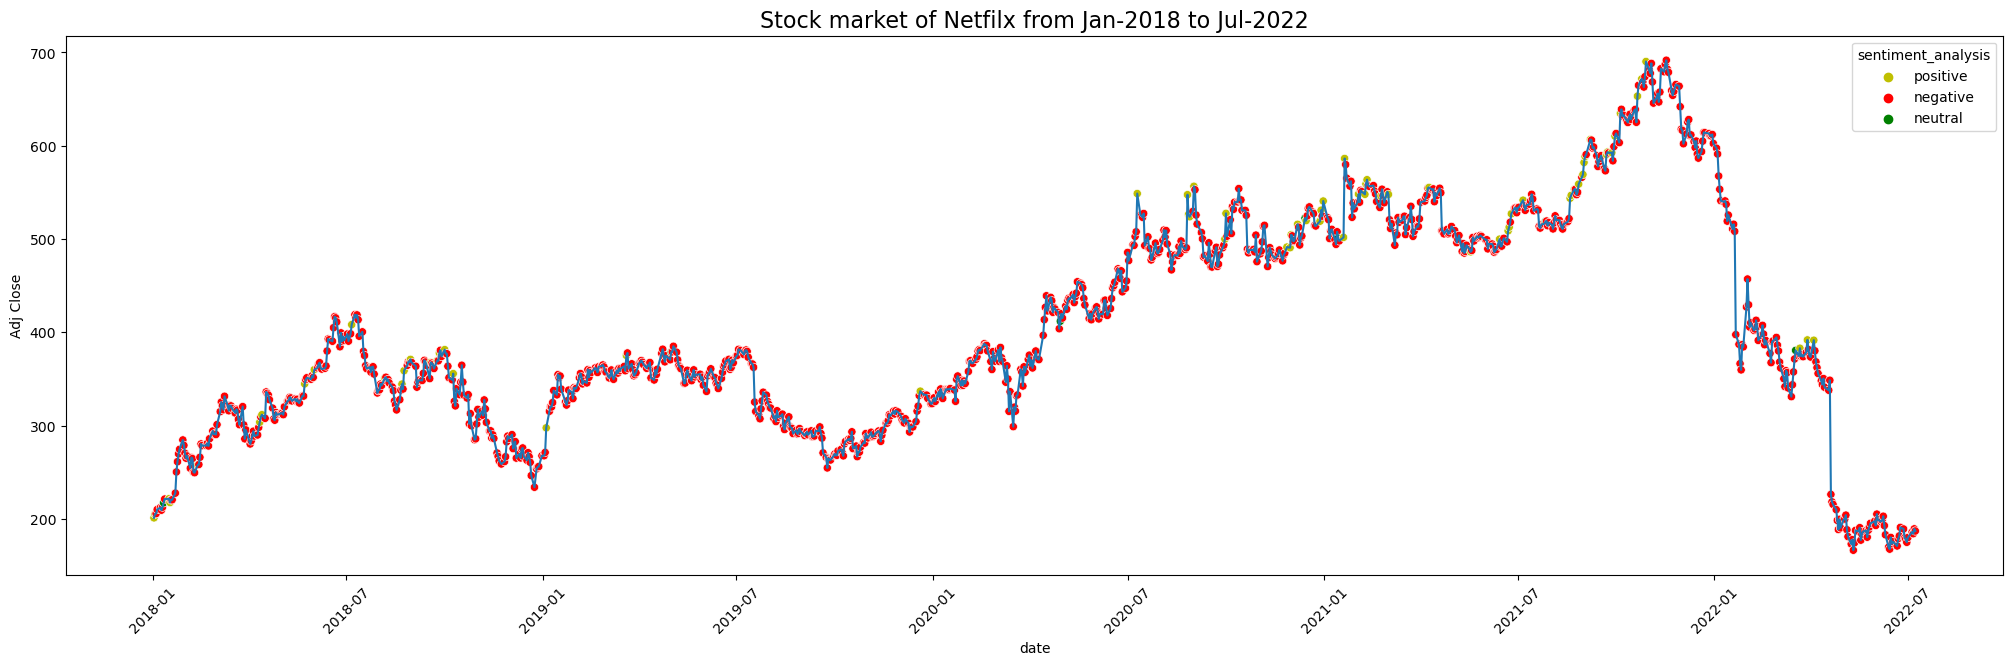

In [8]:
import seaborn as sns
plt.figure(figsize=(25,7));
sns.lineplot(x=df["date"],y=df["Adj Close"])
df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'positive' if x>0 else 'neutral' if x==0 else 'negative')
sns.scatterplot(x=df["date"],y=df['Adj Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of Netfilx from Jan-2018 to Jul-2022",fontsize=16);

In [9]:
## Generate the value counts for each of the categories
df['sentiment_analysis'].value_counts()

negative    1059
positive      71
neutral        7
Name: sentiment_analysis, dtype: int64

- The following code prepares the dataset for training by selecting relevant columns, converting data types, and setting up the index based on time. The resulting DataFrame `df_for_training` is streamlined for use in model training.

In [10]:
#Convert the date column in the DataFrame df into a datetime format 
train_dates = pd.to_datetime(df['date'])
#These are selected variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean',
        ]
#Date and volume columns are not used in training.

print(cols)

#New dataframe with only training data
df_for_training = df[cols].astype(float)
df_for_training.index=df['date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
date,,,,,,,
2018-01-02,196.100006,201.649994,195.419998,201.070007,10966900.0,201.070007,0.020833
2018-01-03,202.050003,206.210007,201.500000,205.050003,8591400.0,205.050003,0.071217
2018-01-04,206.199997,207.050003,204.000000,205.630005,6029600.0,205.630005,-0.018519
2018-01-05,207.250000,210.020004,205.589996,209.990005,7033200.0,209.990005,-0.019737
2018-01-08,210.020004,212.500000,208.440002,212.050003,5580200.0,212.050003,-0.007663
...,...,...,...,...,...,...,...
2022-07-01,176.490005,180.100006,174.270004,179.949997,5194700.0,179.949997,-0.062315
2022-07-05,176.279999,185.919998,172.679993,185.880005,7334300.0,185.880005,-0.058824
2022-07-06,185.199997,186.220001,180.820007,184.059998,5753400.0,184.059998,-0.014870


# LSTM Model

## Data scaling for LSTM
- Reasons for data scaling: The code's data scaling process is essential to ensure the effectiveness of the neural network model. By scaling features such as opening and closing prices, trading volume, and sentiment analysis scores, the model's convergence is enhanced, preventing domination by features with larger magnitudes. Additionally, using separate scalers for training and inference maintains data consistency and prepares new data for prediction in a scaled manner, ultimately contributing to more accurate and stable stock price predictions.

This code segment involves data scaling using the Min-Max Scaler from scikit-learn and the creation of separate scalers for training and inference:

1. `scaler = MinMaxScaler()`: Initializes a Min-Max Scaler object, used to transform the training data.

2. `scaler = scaler.fit(df_for_training)`: Calculates the scaling factors based on the minimum and maximum values of each feature in the training dataset.

3. `df_for_training_scaled = scaler.transform(df_for_training)`: Applies the scaling to the entire dataFrame. This ensures that the training data is scaled consistently for model training.

4. `scaler_for_inference = MinMaxScaler()`: Initializes a separate Min-Max Scaler object. This scaler is intended for transforming new data when making predictions.

5. `scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])`: Fits the `scaler_for_inference` to a subset of the `df_for_training` DataFrame containing only the "Open" and "Adj Close" columns. This step calculates scaling factors specific to these features.

The DataFrame `df_for_training_scaled` now contains the scaled training data. This scaled data is prepared for use in training machine learning models.

In [18]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled

array([[0.17239161, 0.16193068, 0.16299819, ..., 0.20085146, 0.15975024,
        0.58996553],
       [0.16449971, 0.16949312, 0.16546293, ..., 0.12256481, 0.18070889,
        0.52005358],
       [0.18743731, 0.18951466, 0.18632733, ..., 0.10732021, 0.19669918,
        0.40552279],
       ...,
       [0.04019756, 0.02677103, 0.03460201, ..., 0.0348554 , 0.03367472,
        0.72879365],
       [0.03843751, 0.03431458, 0.03972256, ..., 0.03924957, 0.04359249,
        0.60725335],
       [0.04174946, 0.03374739, 0.03828956, ..., 0.03544446, 0.03923323,
        0.6444625 ]])

## Reshape data into n_samples x timesteps x n_features
In this code segment, empty lists `trainX` and `trainY` are initialized to hold formatted training data. Variables `n_future` and `n_past` define the prediction horizon and historical context. The code iterates over the dataset, creating sequences of past data (`trainX`) to predict future data points (`trainY`). The resulting arrays `trainX` and `trainY` store the reshaped training data, with their shapes printed for confirmation. This step prepares the data for training by organizing it into input-output pairs suitable for machine learning models.

In [20]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days to look into the future based on the past days.
n_past = 5  # Number of past days to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (1118, 5, 7).
TrainY shape = (1118, 1, 2).


## Train test split for LSTM
- This code splits the dataset into training and testing sets twice. The first split excludes the last feature dimension (Twitter features), while the second split includes all features, for further sentiment analysis with and without Twitter features.

In [26]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((894, 5, 6), (894, 5, 7))

## Train validation split for LSTM
- This code employs `train_test_split` from scikit-learn to divide the data into training and validation sets for both cases: without and with Twitter sentiment analysis. A validation subset (10%) is extracted without shuffling.

In [27]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_val_lstm_without_twitter, y_train_lstm_without_twitter, y_val_lstm_without_twitter = train_test_split(X_train_lstm_without_twitter, y_train_lstm_without_twitter, test_size=0.1, shuffle=False)

X_train_lstm_twitter, X_val_lstm_twitter, y_train_lstm_twitter, y_val_lstm_twitter = train_test_split(X_train_lstm_twitter, y_train_lstm_twitter, test_size=0.1, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((804, 5, 6), (804, 5, 7))

## Model architecture
Overall, this section defines a deep learning model for processing sequential data. It combines convolutional layers, bidirectional LSTMs, and fully connected layers to learn patterns in the data for a regression task. 

**Model Architecture:**
   - The model is of type `Sequential`, indicating a linear stack of layers.
   - The first layer is a 1D convolutional layer (`Conv1D`) with 128 filters, kernel size 2, and valid padding. The input shape matches the `input_shape` parameter.
   - A max pooling layer (`MaxPooling1D`) follows the convolutional layer, reducing the feature map size by taking the maximum value over each pool of 2 consecutive values.
   - Another 1D convolutional layer is added with 64 filters and kernel size 2, again using valid padding.
   - Another max pooling layer follows this convolutional layer, with a pool size of 1 and stride of 2. (Note: This layer is commented out.)
   - The model then incorporates bidirectional Long Short-Term Memory (LSTM) layers. First, one bidirectional LSTM with 256 units is added, which returns sequences.
   - A dropout layer with 20% dropout rate is applied to mitigate overfitting.
   - Another bidirectional LSTM with the same configuration is added, followed by another dropout layer.
   
**Fully Connected Layers:**
   - A densely connected (`Dense`) layer with 32 units and ReLU activation is added.
   - Another dense layer is added, with the number of units equal to the number of output dimensions in the training labels (`trainY`), and ReLU activation.

**Model Compilation:**
   The model is compiled using the Adam optimizer and mean squared error (`mse`) loss function. This suggests that the model is intended for regression tasks where it predicts continuous values.

In [28]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [30]:
# fit the model

cnn_lstm_model_without_twitter=build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
cnn_lstm_model_twitter=build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_twitter, y_val_lstm_without_twitter), verbose=1, )


history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_twitter, y_val_lstm_twitter), verbose=1, )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 4, 128)            1664      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 2, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 bidirectional_4 (Bidirecti  (None, 1, 512)            657408    
 onal)                                                           
                                                      

## Plotting Training and validation loss
- The higher training loss observed initially in the plot without Twitter features compared to the plot with Twitter features indicates that the model struggles to fit the training data as effectively when Twitter features are omitted. This difference arises because the Twitter features likely provide valuable insights to help capture underlying patterns in the data.

- However, as training progresses, the losses of both models converge and become nearly identical. This convergence might imply that after a certain point, the non-Twitter model manages to compensate for the absence of Twitter features and approximate the performance of the model with those features.

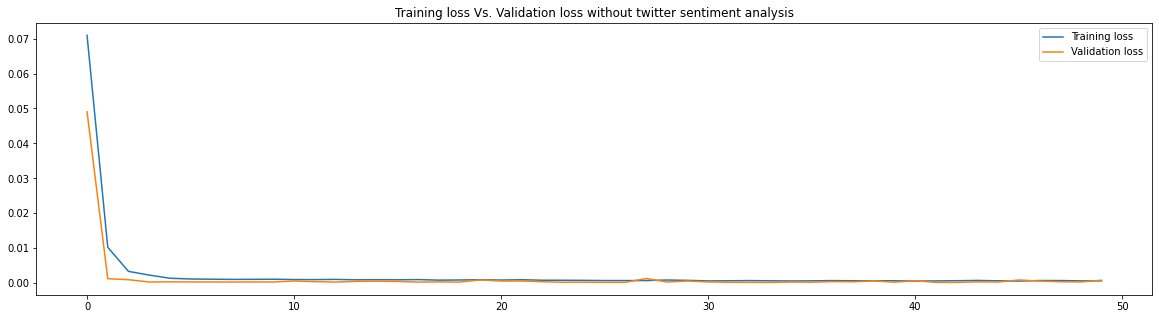

In [13]:
plt.figure(figsize=(20,5))
plt.plot(history_without_twitter.history['loss'], label='Training loss')
plt.plot(history_without_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without twitter sentiment analysis')
plt.legend()

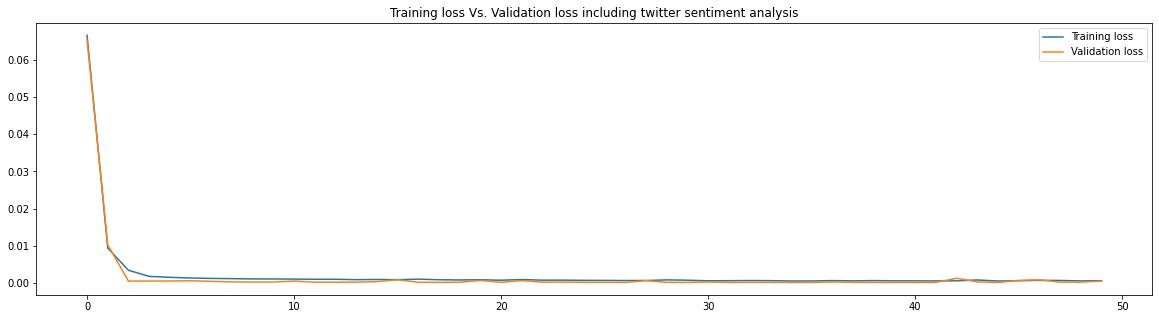

In [14]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.plot(history_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including twitter sentiment analysis')
plt.legend()

## Plotting
This code defines a function, `plot_predictions_with_dates`, for visualizing and evaluating predictions made by a Long Short-Term Memory (LSTM) model for financial data, along with optional Twitter sentiment analysis. Here's the detailed breakdown:

1. **Function Definition:**
   The function `plot_predictions_with_dates` takes several parameters:
   - `type`: Specifies the type of LSTM prediction.
   - `twitter`: A boolean indicating whether Twitter sentiment analysis was used.
   - `dates`: An array of dates corresponding to the predictions.
   - `y_actual_lstm`: Actual values (ground truth) for the predicted features.
   - `y_pred_lstm`: Predicted values for the predicted features.

2. **Plotting Predictions:**
   The function begins by plotting the actual and predicted values for each predicted feature using the `sns.lineplot` function from the Seaborn library. The plots are created separately for each feature and include labels for the actual and predicted lines. The plot's title reflects whether Twitter sentiment analysis was included or not.

3. **Calculating Errors:**
   For each predicted feature, mean squared error (MSE) is calculated using the `mean_squared_error` function from `sklearn.metrics`. The MSE measures the average squared difference between actual and predicted values. The MSE for each feature is printed out.

4. **Total Mean Square Error:**
   After looping through all features, the code calculates and prints the total mean squared error for all predicted features combined.

In [32]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

# Computing training accuracy
The code involves prediction, comparison, and evaluation of a hybrid CNN-LSTM model for time series data. It ensures that the predictions and ground truth data are in the same shape and scale.

1. **Extracting Training Dates:**
The code starts by extracting a subset of training dates from the DataFrame that holds the training data. The number of dates extracted matches the number of rows in the `X_train_lstm_without_twitter` array.

2. **Making Predictions:**
 Two different models are used to predict the outputs based on the training inputs `X_train_lstm_without_twitter` and `X_train_lstm_twitter`, respectively. These models are hybrid models combining convolutional and LSTM layers, designed to predict values in time series data.

3. **Reshaping Predictions:**
The predictions made by the models are reshaped to match the structure of the ground truth data. This step ensures that the predicted values can be compared with the actual values correctly.

4. **Inverse Scaling - Predictions:**
The code uses the `scaler_for_inference` to reverse the data scaling operation, bringing the predictions back to their original scale for meaningful comparison.

5. **Reshaping Ground Truth - Predictions:**
The original ground truth data, which is often in a different shape compared to the predictions, is reshaped to match the shape of the predictions.

6. **Inverse Scaling - Ground Truth:**
This step undoes the scaling operation on the reshaped ground truth data, restoring it to its original scale.

In [33]:
training_dates= df_for_training.index[:X_train_lstm_without_twitter.shape[0]]
#Make prediction
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)

training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)

training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])

training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])

y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)

y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)

y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)

26/26 [==============================] - 1s 3ms/step


###  Training accuracy without twitter
- Close alignment between actual and predicted values in the plots suggests that the models are accurately capturing the underlying patterns in the data.

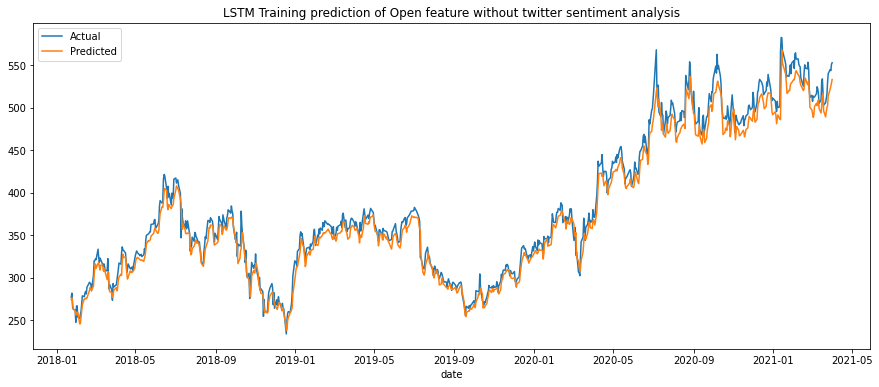

Mean square error for Open =162.33441189827212


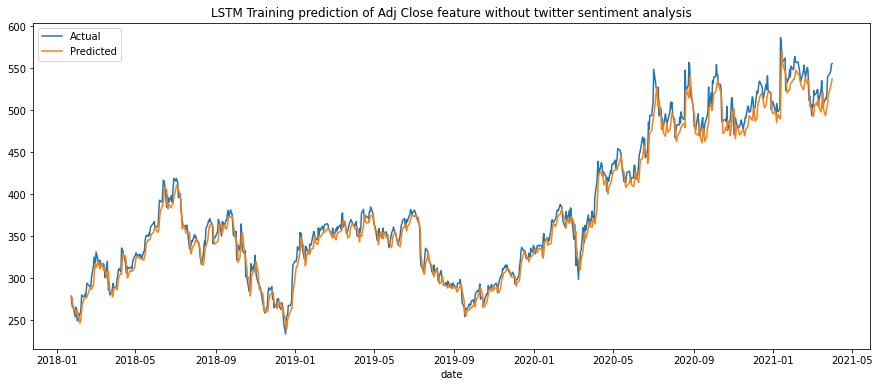

Mean square error for Adj Close =175.9916355376002
Total mean square error 169.16302371793614


In [17]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_twitter)

### Thank you!